# Lasso Random CV Initial

## Preprocess Data

In [6]:
import numpy as np
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))

from Models.LinearRegression import LinearRegression
from Utils.Preprocessor import Preprocessor
from Utils.Utils import root_mean_squared_error, train_test_split, initial_preprocessing, feature_elimination
from Utils.CrossValidation import KFoldCrossValidation
from Utils.Pipeline import Pipeline

In [7]:
# Read the data
train = pd.read_csv('../Data/train.csv', index_col='Id')
# Remove unnecessary features based on exploratory data analysis part 1.
train = initial_preprocessing(train)
train = feature_elimination(train)
X = train.drop(columns=["num_wins_agent1", "num_draws_agent1", "num_losses_agent1", "utility_agent1"], axis=1)
y = train["utility_agent1"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# clip the dataset
X_train = X_train[0:50000]
y_train = y_train[0:50000]

## Randomized CV

In [10]:
# Randomized Cross Validation
num_folds = 5
num_iterations = 10
l1_range = np.logspace(-4, -1, 10)
learning_rate_range = np.logspace(-3, -2, 10)
num_epoch_range = np.logspace(2, np.log10(500), 10).astype(int)
results = []

for i in range(num_iterations):
    l1 = np.random.choice(l1_range)
    learning_rate = np.random.choice(learning_rate_range)
    num_epochs = np.random.choice(num_epoch_range)
    pipeline = Pipeline(Preprocessor(normalize=True, standardize=False, one_hot_encode=True), LinearRegression(fit_method="gd", loss_function="rmse", l1=l1, learning_rate=learning_rate, epochs=num_epochs, gradient_descent='batch'))
    print(f"Iteration {i+1} / {num_iterations} l1: {l1:.6f}, learning_rate: {learning_rate:.6f}, num_epochs: {num_epochs}")

    cross_val = KFoldCrossValidation(pipeline, X, y, num_folds)
    mean_score = cross_val.mean_score()
    results.append((l1, mean_score))

    print(f"Finished iteration {i + 1}/{num_iterations}, score: {mean_score:.6f}")
    print()
sorted_results = sorted(results, key=lambda x: x[1])

print("L1 Parameter | Score")
print("-" * 25)
for l1, score in sorted_results:
    print(f"{l1:.6f} | {score:.6f}")

best_l1, best_score = sorted_results[0]
print(f"\nBest L1: {best_l1:.6f}")
print(f"Best Score: {best_score:.6f}")

Iteration 1 / 10 l1: 0.046416, learning_rate: 0.005995, num_epochs: 244
Finished iteration 1/10, score: 0.615665

Iteration 2 / 10 l1: 0.002154, learning_rate: 0.007743, num_epochs: 292
Finished iteration 2/10, score: 0.608832

Iteration 3 / 10 l1: 0.021544, learning_rate: 0.010000, num_epochs: 119
Finished iteration 3/10, score: 0.616333

Iteration 4 / 10 l1: 0.046416, learning_rate: 0.003594, num_epochs: 292
Finished iteration 4/10, score: 0.616790

Iteration 5 / 10 l1: 0.004642, learning_rate: 0.001668, num_epochs: 292
Finished iteration 5/10, score: 0.619843

Iteration 6 / 10 l1: 0.010000, learning_rate: 0.004642, num_epochs: 119
Finished iteration 6/10, score: 0.618946

Iteration 7 / 10 l1: 0.004642, learning_rate: 0.001000, num_epochs: 349
Finished iteration 7/10, score: 0.620476

Iteration 8 / 10 l1: 0.021544, learning_rate: 0.010000, num_epochs: 499
Finished iteration 8/10, score: 0.606315

Iteration 9 / 10 l1: 0.046416, learning_rate: 0.001292, num_epochs: 142
Finished iterati

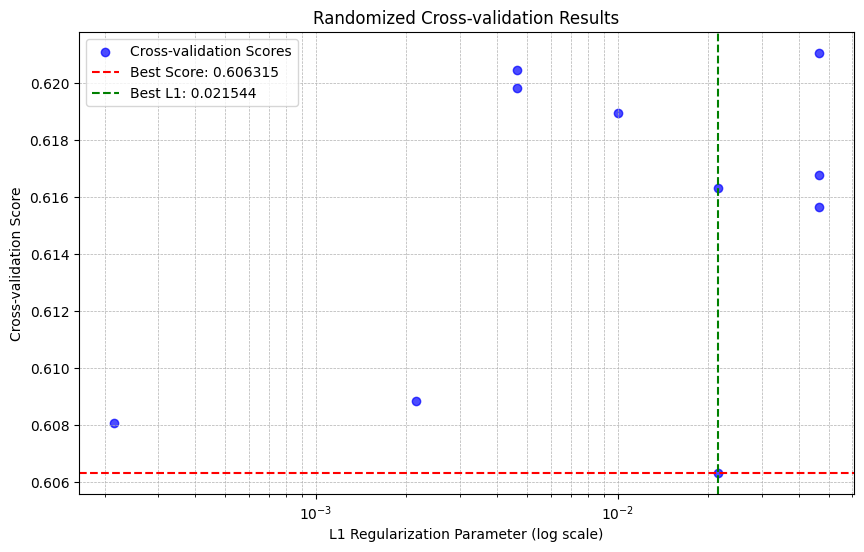

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the L1 parameters and scores from the results
l1_parameters = [result[0] for result in results]
scores = [result[1] for result in results]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(l1_parameters, scores, color='blue', alpha=0.7, label='Cross-validation Scores')
plt.xscale('log')  # Since L1 values are on a log scale
plt.xlabel('L1 Regularization Parameter (log scale)')
plt.ylabel('Cross-validation Score')
plt.title('Randomized Cross-validation Results')
plt.axhline(y=best_score, color='red', linestyle='--', label=f'Best Score: {best_score:.6f}')
plt.axvline(x=best_l1, color='green', linestyle='--', label=f'Best L1: {best_l1:.6f}')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()